In [31]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
import holoviews as hv
from scipy import stats
import scipy
import shutil

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate, Permute, Multiply, Reshape

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor

from joblib import dump, load, parallel_backend, Parallel, delayed


from tensorflow.keras.utils import to_categorical, plot_model
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.layers import Dropout
from keras.models import load_model
from keras_tuner import RandomSearch
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1, l2, l1_l2
from tensorflow.keras import layers


from keras_tuner import RandomSearch
from keras_tuner import BayesianOptimization
from keras_tuner import Hyperband
import keras_tuner as kt

In [3]:
# read in the imputed dataframes as combined_survey
combined_survey = pd.read_csv('Resources/survey_imputed/2010_imputed.csv')
for year in range(2011, 2023):
    df = pd.read_csv(f'Resources/survey_imputed/{year}_imputed.csv')
    combined_survey = pd.concat([combined_survey, df], ignore_index=True)

combined_survey.head()

,year,agency,my_work_experience,my_work_unit,my_organization,my_supervisor,leadership,my_satisfaction,employee_experience,circumstantial,DEIA,negativity_index
0,2010,AF,2.894737,3.111111,0.0,0.0,0.0,0.0,0.000000,0.0,3.506584,0.0
1,2010,AF,4.052632,2.555556,0.0,0.0,0.0,0.0,0.000000,0.0,3.482190,0.0
2,2010,AF,3.526316,3.000000,3.0,3.9,3.5,3.0,4.066667,0.0,3.253816,4.0
3,2010,AF,5.000000,4.222222,0.0,0.0,0.0,0.0,0.000000,0.0,3.448078,0.0
4,2010,AF,3.684211,3.444444,0.0,0.0,0.0,0.0,0.000000,0.0,3.432955,0.0


In [4]:
def describe_stats_by_agency_and_year(df, features, year_column='year', agency_column='agency'):
    """
    Generate descriptive statistics for specified features grouped by agency and year in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - features (list): A list of feature column names for which descriptive statistics are to be generated.
    - agency_column (str, optional): The name of the column representing agencies. Default is 'agency'.
    - year_column (str, optional): The name of the column representing years. Default is 'year'.

    Returns:
    - pd.DataFrame: Descriptive statistics for the specified features grouped by agency and year.
    """
    # Check if the agency and year columns exist in the DataFrame
    if agency_column not in df.columns or year_column not in df.columns:
        return f"Error: Columns '{agency_column}' or '{year_column}' not found in the DataFrame."

    # Check if all specified features exist in the DataFrame
    missing_features = set(features) - set(df.columns)
    if missing_features:
        return f"Error: Columns {missing_features} not found in the DataFrame."


    # Iterate through each feature and calculate descriptive statistics

    stats_by_agency_and_year = df.groupby([year_column, agency_column]).describe()
    # Remove 'min' and 'max' columns

    return stats_by_agency_and_year

# Example usage:
# Assuming 'df' is your DataFrame
# and 'feature_columns' is a list of feature column names for which you want descriptive statistics
df = combined_survey.copy()
feature_columns = ['my_work_experience', 'my_work_unit', 'my_organization', 'my_supervisor', 'leadership', 'my_satisfaction', 'employee_experience', 'circumstantial', 'DEIA', 'negativity_index']
result = describe_stats_by_agency_and_year(df, feature_columns)

# Round the result to 2 decimals
rounded_stats = round(result, 2)
# rename level 1 columns with 25%, 50%, 75% to Q1, Q2, Q3
rounded_stats.rename(columns={'25%': 'Q1', '50%': 'Q2', '75%': 'Q3'}, inplace=True)
# rename the level 1 columns as level 0 _ level 1
rounded_stats.columns = rounded_stats.columns.map('_'.join)

# reset the index
rounded_stats.reset_index(inplace=True)

rounded_stats.head()


,year,agency,my_work_experience_count,my_work_experience_mean,my_work_experience_std,my_work_experience_min,my_work_experience_Q1,my_work_experience_Q2,my_work_experience_Q3,my_work_experience_max,...,DEIA_Q3,DEIA_max,negativity_index_count,negativity_index_mean,negativity_index_std,negativity_index_min,negativity_index_Q1,negativity_index_Q2,negativity_index_Q3,negativity_index_max
0,2010,AF,10560.0,3.89,0.64,0.0,3.53,3.95,4.32,5.0,...,4.16,4.99,10560.0,4.16,1.15,0.0,3.67,4.33,5.0,5.0
1,2010,AR,19413.0,3.88,0.63,0.0,3.53,3.95,4.32,5.0,...,4.16,4.98,19413.0,4.10,1.15,0.0,3.67,4.33,5.0,5.0
2,2010,NV,12378.0,3.86,0.62,0.0,3.47,3.89,4.26,5.0,...,4.14,5.00,12378.0,4.17,1.17,0.0,3.67,4.33,5.0,5.0
3,2011,AF,8775.0,3.87,0.65,0.0,3.47,3.89,4.32,5.0,...,4.10,4.96,8775.0,4.06,1.31,0.0,3.67,4.33,5.0,5.0
4,2011,AR,18827.0,3.89,0.63,0.0,3.53,3.95,4.32,5.0,...,4.11,4.95,18827.0,4.08,1.21,0.0,3.67,4.33,5.0,5.0


In [5]:
#read in all end strength csvs and combine into one dataframe 2008-2023
end_strength_2008 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_200809.csv')
end_strength_2009 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_200909.csv')
end_strength_2010 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201009.csv')
end_strength_2011 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201109.csv')
end_strength_2012 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201209.csv')
end_strength_2013 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201309.csv')
end_strength_2014 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201409.csv')
end_strength_2015 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201509.csv')
end_strength_2016 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201609.csv')
end_strength_2017 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201709.csv')
end_strength_2018 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201809.csv')
end_strength_2019 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201909.csv')
end_strength_2020 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_202009.csv')
end_strength_2021 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_202109.csv')
end_strength_2022 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_202209.csv')
end_strength_2023 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_202309.csv')

# add a Space Force column to each dataframe before 2023
for year in range(2008, 2023):
    eval(f'end_strength_{year}')['Space Force'] = 0

#rename the 2nd column to Rank
for year in range(2008, 2024):
    eval(f'end_strength_{year}').rename(columns={eval(f'end_strength_{year}').columns[1]: 'Rank'}, inplace=True)



# replace rank values with O10, O9, O8, O7, O6, O5, O4, O3, O2, O1, W5, W4, W3, W2, W1, E9, E8, E7, E6, E5, E4, E3, E2, E1
# O11 coincides with the first row of the dataframe, O10 with the second, etc.

for year in range(2008, 2024):
    ranks = ['O10', 'O9', 'O8', 'O7', 'O6', 'O5', 'O4', 'O3', 'O2', 'O1', 'W5', 'W4', 'W3', 'W2', 'W1', 'E9', 'E8', 'E7', 'E6', 'E5', 'E4', 'E3', 'E2', 'E1']
    for i in range(len(ranks)):
        eval(f'end_strength_{year}').loc[i, 'Rank'] = ranks[i]


# create internal loop to rename the columns for each year
for year in range(2008, 2024):
    dataframe_name = f'end_strength_{year}'
    df = globals()[dataframe_name]
    # convert the cuears}'rrent year column names to Army: AR, Navy: NV, Air Force: AF, Space Force: AF, Marine Corps: MC
    df.rename(columns={'Army': 'AR', 'Navy': 'NV', 'Air Force': 'AF', 'Space Force': 'SF', 'Marine Corps': 'MC'}, inplace=True)

    # sum the values of the Navy and Marine Corps columns and rewrite the values in the Navy column
    df['NV'] = df['NV'] + df['MC']
    # drop the Marine Corps column
    df.drop(columns='MC', inplace=True)
    #drop the Space Force column
    df.drop(columns='SF', inplace=True)

    # rename Year to year
    df.rename(columns={'Year': 'year'}, inplace=True)

    # split each dataframe into service data frames per year
    df_AR = df[['year', 'Rank', 'AR']]
    df_NV = df[['year', 'Rank', 'NV']]
    df_AF = df[['year', 'Rank', 'AF']]

    #export each dataframe to a csv as year_service.csv
    df_AR.to_csv(f'Resources/end_strength/service_by_year/{year}_AR.csv', index=False)
    df_NV.to_csv(f'Resources/end_strength/service_by_year/{year}_NV.csv', index=False)
    df_AF.to_csv(f'Resources/end_strength/service_by_year/{year}_AF.csv', index=False)

    globals()[dataframe_name] = df

for service in ['AR', 'NV', 'AF']:    
    for year in range(2010, 2023):


        # Construct the variable name for the dataframe
        dataframe_service_current = pd.read_csv(f'Resources/end_strength/service_by_year/{year}_{service}.csv')
        dataframe_service_previous = pd.read_csv(f'Resources/end_strength/service_by_year/{year - 1}_{service}.csv')
        dataframe_service_previous2 = pd.read_csv(f'Resources/end_strength/service_by_year/{year - 2}_{service}.csv')
        dataframe_service_next = pd.read_csv(f'Resources/end_strength/service_by_year/{year + 1}_{service}.csv')

        dataframe_service_current['minus_1'] = dataframe_service_previous[f'{service}']
        dataframe_service_current['minus_2'] = dataframe_service_previous2[f'{service}']
        dataframe_service_current['plus_1'] = dataframe_service_next[f'{service}']

        dataframe_service_current['minus_1'] = dataframe_service_current[f'{service}'] - dataframe_service_current['minus_1']
        dataframe_service_current['minus_2'] = dataframe_service_current[f'{service}'] - dataframe_service_current['minus_2']
        dataframe_service_current['plus_1'] = dataframe_service_current['plus_1'] - dataframe_service_current[f'{service}']

        #if plus_1 is negative, make it 0 to indicate a decrease in end strength, otherwise make it 1 to indicate an increase
        dataframe_service_current['slope'] = np.where(dataframe_service_current['plus_1'] < 0, 0, 1)

        dataframe_service_current.rename(columns={f'{service}': 'current'}, inplace=True)

        dataframe_service_current['agency'] = service

        column_order = ['year', 'agency', 'Rank', 'minus_2', 'minus_1', 'current', 'plus_1', 'slope']
        dataframe_service_current = dataframe_service_current[column_order]

        #export each dataframe to a csv as year_service_comparison.csv
        dataframe_service_current.to_csv(f'Resources/end_strength/service_by_year/{year}_{service}_comparison.csv', index=False)

# Create master dataframe for end strength
end_strength = pd.DataFrame(columns=['year', 'agency', 'Rank', 'minus_2', 'minus_1', 'current', 'plus_1', 'slope'])

for service in ['AR', 'NV', 'AF']:
    for year in range(2010, 2023):
        dataframe_service_current = pd.read_csv(f'Resources/end_strength/service_by_year/{year}_{service}_comparison.csv')
        end_strength = pd.concat([end_strength, dataframe_service_current], ignore_index=True)
    
    #delete the year_service.csv files
    for year in range(2008, 2024):
        os.remove(f'Resources/end_strength/service_by_year/{year}_{service}.csv')

end_strength.to_csv('Resources/end_strength/end_strength_combined.csv', index=False)
    

# print test dataframe
print(pd.read_csv('Resources/end_strength/service_by_year/2022_AR_comparison.csv').head(25))









    year agency Rank  minus_2  minus_1  current  plus_1  slope
0   2022     AR  O10       -1        0       16      -1      0
1   2022     AR   O9       -1       -2       46      -2      0
2   2022     AR   O8       15        3      108     -13      0
3   2022     AR   O7      -20      -11      118      -5      0
4   2022     AR   O6     -235     -136     3767    -113      0
5   2022     AR   O5     -127     -237     8902    -207      0
6   2022     AR   O4       74      -48    16131    -164      0
7   2022     AR   O3       68      -15    27212    -457      0
8   2022     AR   O2      -55      -77    12209      93      1
9   2022     AR   O1      261      374    10111    -628      0
10  2022     AR   W5       20       28      571     -14      0
11  2022     AR   W4     -101     -124     1848     -94      0
12  2022     AR   W3     -301     -136     3339    -177      0
13  2022     AR   W2      413       91     5940     -31      0
14  2022     AR   W1      669      508     3343     722

In [6]:
# combine all of the end strength dataframes into one dataframe
all_end_strength = end_strength.copy()

all_end_strength.head()

,year,agency,Rank,minus_2,minus_1,current,plus_1,slope
0,2010,AR,O10,0,1,12,0,1
1,2010,AR,O9,-5,-3,49,1,1
2,2010,AR,O8,16,2,100,8,1
3,2010,AR,O7,-11,-11,157,-13,0
4,2010,AR,O6,101,-3,4356,78,1


In [7]:
print(end_strength.shape)
print(end_strength.head())

(936, 8)
   year agency Rank minus_2 minus_1 current plus_1 slope
0  2010     AR  O10       0       1      12      0     1
1  2010     AR   O9      -5      -3      49      1     1
2  2010     AR   O8      16       2     100      8     1
3  2010     AR   O7     -11     -11     157    -13     0
4  2010     AR   O6     101      -3    4356     78     1


In [82]:
# for adding survey to PCAs
survey_pca = all_end_strength.merge(rounded_stats, how='left', left_on=['agency', 'year'], right_on=['agency', 'year'])
with_year = survey_pca.copy()
# drop the year column
survey_pca.drop(columns='year', inplace=True)

In [109]:
# Conduct K means clustering on the all_surveys dataframe
# Create a copy of the dataframe

df = combined_survey.copy()
#df = survey_pca.copy()

df.head()

,year,agency,my_work_experience,my_work_unit,my_organization,my_supervisor,leadership,my_satisfaction,employee_experience,circumstantial,DEIA,negativity_index
0,2010,AF,2.894737,3.111111,0.0,0.0,0.0,0.0,0.000000,0.0,3.506584,0.0
1,2010,AF,4.052632,2.555556,0.0,0.0,0.0,0.0,0.000000,0.0,3.482190,0.0
2,2010,AF,3.526316,3.000000,3.0,3.9,3.5,3.0,4.066667,0.0,3.253816,4.0
3,2010,AF,5.000000,4.222222,0.0,0.0,0.0,0.0,0.000000,0.0,3.448078,0.0
4,2010,AF,3.684211,3.444444,0.0,0.0,0.0,0.0,0.000000,0.0,3.432955,0.0


In [110]:


all_columns = set(df.columns)
categorical_columns = {'agency'} #, 'year', 'Rank'

# Define feature_columns as all columns except categorical and target columns
feature_columns = list(all_columns - categorical_columns)

categorical_columns = list(categorical_columns)





#feature_columns = ['my_work_experience', 'my_work_unit', 'my_organization', 'my_supervisor', 'leadership', 'my_satisfaction', 'employee_experience', 'circumstantial', 'DEIA', 'negativity_index']
#categorical_columns = ['agency']
# Separate feature and categorical dataframes
df_feature = df[feature_columns]
df_categorical = df[categorical_columns]

# Convert categorical data to dummy variables
df_categorical = pd.get_dummies(df_categorical)

# Replace NaN values in feature dataframe with 0
df_feature = df_feature.fillna(0)

# Implement standard scaler on continuous features
scaler = StandardScaler()
scaled_df_feature = scaler.fit_transform(df_feature)

# Convert the scaled feature array back to a dataframe
scaled_df_feature = pd.DataFrame(scaled_df_feature, columns=feature_columns)

# Combine the scaled feature dataframe with the categorical dummy dataframe
final_df = pd.concat([scaled_df_feature, df_categorical], axis=1)

# Conduct PCA
pca1 = PCA(n_components=5)
pca2 = PCA(n_components=5)
pca_df_combined = pca1.fit_transform(final_df)
pca_df_feature = pca2.fit_transform(scaled_df_feature)

# Print explained variance ratio
print(f'Combined Feature and Agency variance explained:  {pca1.explained_variance_ratio_}')
print(f'Feature only variance explained: {pca2.explained_variance_ratio_}')

# Create a dataframe with the PCAs
pca_df = pd.DataFrame(pca_df_feature, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'])




Combined Feature and Agency variance explained:  [0.46864143 0.15654419 0.09810629 0.07240797 0.03942426]
Feature only variance explained: [0.49618667 0.16544367 0.10386913 0.0766344  0.04170143]


In [111]:
pca_df.shape

(1254450, 5)

In [112]:
# Elbow curve
inertia = []
k = list(range(1, 11))

for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pca_df)
    inertia.append(km.inertia_)

c:\Users\raymm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\raymm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\raymm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\raymm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

In [113]:
# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}

# Create the DataFrame from the elbow data
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

,k,inertia
0,1,1.219600e+07
1,2,7.695547e+06
2,3,6.271811e+06
3,4,5.414266e+06
4,5,4.687614e+06


In [114]:
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

c:\Users\raymm\anaconda3\lib\site-packages\holoviews\core\data\pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
c:\Users\raymm\anaconda3\lib\site-packages\holoviews\core\data\pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Curve   [k]   (inertia)

In [115]:
model = KMeans(n_clusters=5, random_state=0)

# Fit the model
model.fit(pca_df)

# Predict clusters
predictions = model.predict(pca_df)

# Add the predicted class columns
all_survey_predictions = df.copy()

all_survey_predictions["cluster"] = predictions


pca_df["cluster"] = predictions

# Review the DataFrame
all_survey_predictions.head()


c:\Users\raymm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,year,agency,my_work_experience,my_work_unit,my_organization,my_supervisor,leadership,my_satisfaction,employee_experience,circumstantial,DEIA,negativity_index,cluster
0,2010,AF,2.894737,3.111111,0.0,0.0,0.0,0.0,0.000000,0.0,3.506584,0.0,4
1,2010,AF,4.052632,2.555556,0.0,0.0,0.0,0.0,0.000000,0.0,3.482190,0.0,4
2,2010,AF,3.526316,3.000000,3.0,3.9,3.5,3.0,4.066667,0.0,3.253816,4.0,0
3,2010,AF,5.000000,4.222222,0.0,0.0,0.0,0.0,0.000000,0.0,3.448078,0.0,4
4,2010,AF,3.684211,3.444444,0.0,0.0,0.0,0.0,0.000000,0.0,3.432955,0.0,4


In [116]:
all_survey_predictions.shape

(1254450, 13)

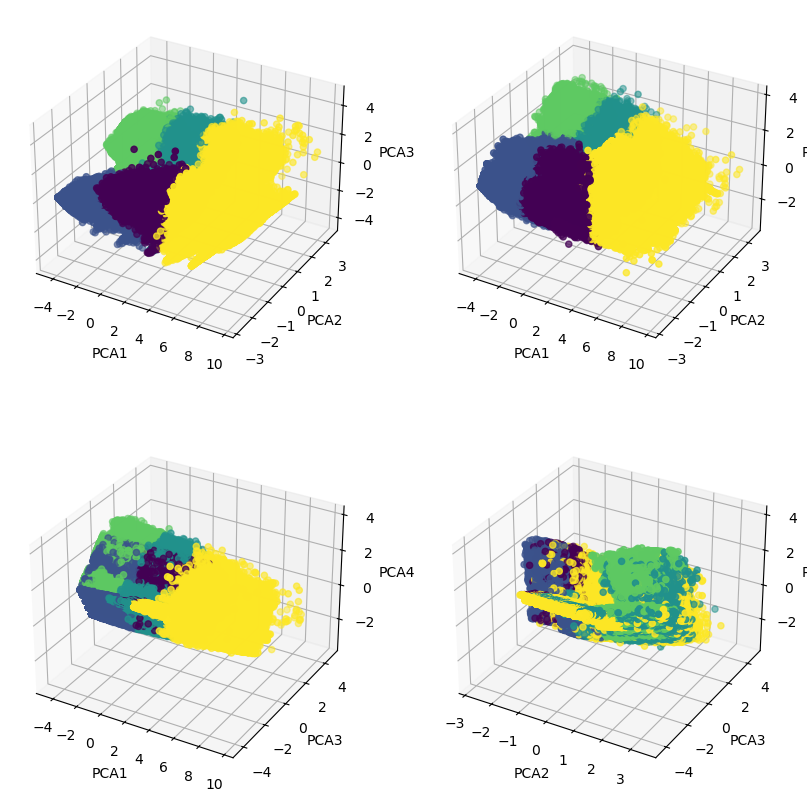

In [117]:
# plot the clusters on a 3D scatter plot
fig = plt.figure(figsize=(10, 10))

# create 4 subplots with different PCA combinations
ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(pca_df['PCA1'], pca_df['PCA2'], pca_df['PCA3'], c=pca_df['cluster'])
ax1.set_xlabel('PCA1')
ax1.set_ylabel('PCA2')
ax1.set_zlabel('PCA3')

ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(pca_df['PCA1'], pca_df['PCA2'], pca_df['PCA4'], c=pca_df['cluster'])
ax2.set_xlabel('PCA1')
ax2.set_ylabel('PCA2')
ax2.set_zlabel('PCA4')

ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(pca_df['PCA1'], pca_df['PCA3'], pca_df['PCA4'], c=pca_df['cluster'])
ax3.set_xlabel('PCA1')
ax3.set_ylabel('PCA3')
ax3.set_zlabel('PCA4')

ax4 = fig.add_subplot(224, projection='3d')
ax4.scatter(pca_df['PCA2'], pca_df['PCA3'], pca_df['PCA4'], c=pca_df['cluster'])
ax4.set_xlabel('PCA2')
ax4.set_ylabel('PCA3')
ax4.set_zlabel('PCA4')


plt.show()

In [118]:
# group by year, agency, and cluster

all_survey_predictions.shape
# one hot encode the cluster column
one_hot_clusters = pd.get_dummies(all_survey_predictions, columns=['cluster'])

#drop feature columns
one_hot_clusters.drop(columns=feature_columns, inplace=True)

# add year column back in
one_hot_clusters['year'] = with_year['year']
#drop predict_year
#one_hot_clusters.drop(columns='predict_year', inplace=True)

# Original Option
grouped_clusters = one_hot_clusters.groupby(['year', 'agency']).sum()

# Less data option
# grouped_clusters = one_hot_clusters.groupby(['year', 'agency', 'Rank']).sum()

# reset the index
grouped_clusters.reset_index(inplace=True)

print(grouped_clusters.head(100))

# save the grouped clusters dataframe to a csv
grouped_clusters.to_csv('Resources/grouped_clusters.csv', index=False)


    year agency  cluster_0  cluster_1  cluster_2  cluster_3  cluster_4
0   2010     AF         30         23          0          0         19
1   2011     AF         35         33          0          0          4
2   2012     AF         38         33          0          0          1
3   2013     AF         33         31          0          0          8
4   2014     AF         30         38          0          0          4
5   2015     AF         29         38          0          0          5
6   2016     AF         33         33          0          0          6
7   2017     AF         30         24          0          0         18
8   2018     AF         38         32          0          0          2
9   2019     AF         34         36          0          0          2
10  2020     AF         33         35          0          0          4
11  2021     AF         38         32          0          0          2
12  2022     AF         33         22          0          0         17


In [119]:
# join the all_surveys and all_end_strength dataframes on agency and year
final_df_1 = all_end_strength.merge(rounded_stats, how='left', left_on=['agency', 'year'], right_on=['agency', 'year'])
final_df_2 = final_df_1.merge(grouped_clusters, how='left', left_on=['agency', 'year'], right_on=['agency', 'year'])

# final df 2 but no rounded stats join
#final_df_2 = all_end_strength.merge(grouped_clusters, how='left', left_on=['agency', 'year'], right_on=['agency', 'year'])

# final df 2 but actually grouped with Rank
#final_df_2 = all_end_strength.merge(grouped_clusters, how='left', left_on=['agency', 'year', 'Rank'], right_on=['agency', 'year', "Rank"])

In [120]:
print(final_df_2.shape)
print(final_df_2.columns)
print(final_df_2.head())

(936, 93)
Index(['year', 'agency', 'Rank', 'minus_2', 'minus_1', 'current', 'plus_1',
       'slope', 'my_work_experience_count', 'my_work_experience_mean',
       'my_work_experience_std', 'my_work_experience_min',
       'my_work_experience_Q1', 'my_work_experience_Q2',
       'my_work_experience_Q3', 'my_work_experience_max', 'my_work_unit_count',
       'my_work_unit_mean', 'my_work_unit_std', 'my_work_unit_min',
       'my_work_unit_Q1', 'my_work_unit_Q2', 'my_work_unit_Q3',
       'my_work_unit_max', 'my_organization_count', 'my_organization_mean',
       'my_organization_std', 'my_organization_min', 'my_organization_Q1',
       'my_organization_Q2', 'my_organization_Q3', 'my_organization_max',
       'my_supervisor_count', 'my_supervisor_mean', 'my_supervisor_std',
       'my_supervisor_min', 'my_supervisor_Q1', 'my_supervisor_Q2',
       'my_supervisor_Q3', 'my_supervisor_max', 'leadership_count',
       'leadership_mean', 'leadership_std', 'leadership_min', 'leadership_Q1',
  

In [121]:
training_base = final_df_2[final_df_2['year'] != 2022].copy()
# drop year column
training_base.drop(columns='year', inplace=True)
production_base = final_df_2[final_df_2['year'] == 2022].copy()
# drop year column
production_base.drop(columns='year', inplace=True)

# for training set 1, drop the slope column - the goal is to predict the slope
training_set_1 = training_base.drop(columns=['plus_1'])
training_set_2 = training_base.copy()

In [122]:
def prepare_data(df, target_column, feature_columns, categorical_columns, test_size=0.2, random_state=0):
    # Create dummy variables for categorical columns
    df = pd.get_dummies(df, columns=categorical_columns)

    # Separate features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Further split the training set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=random_state)

    # Create and fit the scaler on the training set
    scaler = StandardScaler()
    scaler.fit(X_train[feature_columns])

    # Scale the data
    X_train_scaled = scaler.transform(X_train[feature_columns])
    X_test_scaled = scaler.transform(X_test[feature_columns])
    X_val_scaled = scaler.transform(X_val[feature_columns])

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

# Define categorical and feature columns
all_columns = set(training_base.columns)
categorical_columns = {'agency', 'Rank'} #, 'year'
target_columns = {'slope', 'plus_1'}

# Define feature_columns as all columns except categorical and target columns
feature_columns = list(all_columns - categorical_columns - target_columns)

categorical_columns = list(categorical_columns)

# Prepare the data for training set 1
X1_train_scaled, X1_val_scaled, X1_test_scaled, y1_train, y1_val, y1_test = prepare_data(
    training_set_1, 'slope', feature_columns, categorical_columns)

# Prepare the data for training set 2
X2_train_scaled, X2_val_scaled, X2_test_scaled, y2_train, y2_val, y2_test = prepare_data(
    training_set_2, 'plus_1', feature_columns, categorical_columns)

# Print shapes to verify
print("Training set 1 shape: ", X1_train_scaled.shape, y1_train.shape)
print("Training set 2 shape: ", X2_train_scaled.shape, y2_train.shape)

Training set 1 shape:  (345, 88) (345,)
Training set 2 shape:  (345, 88) (345,)


In [123]:
# ensure the data type is ready for the model
y1_train = y1_train.astype('int')
y1_val = y1_val.astype('int')
y1_test = y1_test.astype('int')

y2_train = y2_train.astype('int')
y2_val = y2_val.astype('int')
y2_test = y2_test.astype('int')



In [124]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X1_train_scaled[0])

# Create a method that creates a new Sequential model with hyperparameter options
def build_model(hp, input_shape):

    model = tf.keras.models.Sequential()
    model.add(layers.Dense(units=hp.Int('units', min_value=1, max_value=500, step=10), activation='relu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l1(0.001)))

    # Tuning the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=1, max_value=500, step=10)
    

    model.add(layers.Dense(units=hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

    model.add(layers.Dense(units=hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.001)))

    # Tuning the dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    model.add(layers.Dropout(rate=hp_dropout))

    # Adding additional hidden layers
    for i in range(hp.Int('num_layers', 1, 50)):
        # Each hidden layer can have its own number of units and dropout rate
        layer_units = hp.Int(f'units_{i}', min_value=1, max_value=200, step=5)
        model.add(layers.Dense(units=layer_units, activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh'])))
        

    # Output layer
    model.add(layers.Dense(units=1, activation='sigmoid'))


    model.compile(optimizer='adam',
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

In [125]:
def clear_project_dir(project_name):
    if os.path.exists(project_name):
        shutil.rmtree(project_name)

clear_project_dir('tuner0')
clear_project_dir('tuner1')

In [126]:
input_shape = X1_train_scaled.shape[1:]

early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Change to 'val_accuracy' if you care more about accuracy
    min_delta=0.01,      # Minimum change to qualify as an improvement
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='auto'          # 'auto' infers from the direction of the monitored metric
)

class AccuracyThresholdCallback(Callback):
    def __init__(self, threshold):
        super(AccuracyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("accuracy")
        if accuracy is not None:
            if accuracy >= self.threshold:
                print(f"\nReached {self.threshold * 100}% accuracy, so stopping training!")
                self.model.stop_training = True

# Instantiate the callback with your desired threshold
accuracy_threshold = AccuracyThresholdCallback(threshold=0.85)


class PerformanceThresholdCallback(Callback):
    def __init__(self, threshold, patience=10):
        super(PerformanceThresholdCallback, self).__init__()
        self.threshold = threshold
        self.patience = patience
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("accuracy")
        if accuracy is not None:
            if accuracy < self.threshold:
                self.wait += 1
                if self.wait >= self.patience:
                    print(f"\nAccuracy did not reach the threshold of {self.threshold * 100}% within {self.patience} epochs. Stopping training.")
                    self.model.stop_training = True
            else:
                self.wait = 0  # reset the counter if performance is good

# Instantiate the callback
performance_threshold = PerformanceThresholdCallback(threshold=0.50, patience=10)  

checkpoint_hyper = ModelCheckpoint(
    "checkpoints/hyper_weights.{epoch:02d}.hdf5",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None
)

checkpoint_bayesian = ModelCheckpoint(
    "checkpoints/bayesian_weights.{epoch:02d}.hdf5",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None
)

# Initialize the tuner
tuner1 = kt.Hyperband(
    lambda hp: build_model(hp, input_shape=input_shape),
    objective='val_accuracy',
    max_epochs=25,
    project_name='tuner0',
    hyperband_iterations=1
)


tuner2 = BayesianOptimization(
    lambda hp: build_model(hp, input_shape=input_shape),
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    project_name='tuner1'
)


In [127]:
tuner1.search(X1_train_scaled, y1_train, 
             epochs=300,
             validation_data=(X1_val_scaled, y1_val),
             callbacks=[early_stopping, accuracy_threshold, performance_threshold, checkpoint_hyper]
             )

Trial 30 Complete [00h 00m 10s]
val_accuracy: 0.5346820950508118

Best val_accuracy So Far: 0.5346820950508118
Total elapsed time: 00h 02m 45s


In [128]:
tuner2.search(X1_train_scaled, y1_train, 
             epochs=300,
             validation_data=(X1_val_scaled, y1_val),
             callbacks=[early_stopping, accuracy_threshold, performance_threshold, checkpoint_bayesian]
             )

Trial 5 Complete [00h 00m 26s]
val_accuracy: 0.5346820950508118

Best val_accuracy So Far: 0.5346820950508118
Total elapsed time: 00h 01m 44s


In [129]:
# Get top 3 model hyperparameters and print the values
top_hyper1 = tuner1.get_best_hyperparameters(3)
for param in top_hyper1:
    print(param.values)

top_hyper2 = tuner2.get_best_hyperparameters(3)
for param in top_hyper2:
    print(param.values)

{'units': 11, 'dropout': 0.25, 'num_layers': 1, 'units_0': 166, 'activation_0': 'tanh', 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
{'units': 71, 'dropout': 0.1, 'num_layers': 14, 'units_0': 46, 'activation_0': 'tanh', 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0, 'units_1': 1, 'activation_1': 'relu', 'units_2': 1, 'activation_2': 'relu', 'units_3': 1, 'activation_3': 'relu', 'units_4': 1, 'activation_4': 'relu', 'units_5': 1, 'activation_5': 'relu', 'units_6': 1, 'activation_6': 'relu', 'units_7': 1, 'activation_7': 'relu', 'units_8': 1, 'activation_8': 'relu', 'units_9': 1, 'activation_9': 'relu', 'units_10': 1, 'activation_10': 'relu', 'units_11': 1, 'activation_11': 'relu', 'units_12': 1, 'activation_12': 'relu', 'units_13': 1, 'activation_13': 'relu'}
{'units': 281, 'dropout': 0.25, 'num_layers': 12, 'units_0': 21, 'activation_0': 'tanh', 'units_1': 6, 'activation_1': 'relu', 'units_2': 21, 'activation_2':

In [130]:
# Get best model hyperparameters
best_hyper1 = tuner1.get_best_hyperparameters(1)[0]
print(f" Hyperband values: {best_hyper1.values}")

best_hyper2 = tuner2.get_best_hyperparameters(1)[0]
print(f"Bayesian values: {best_hyper2.values}")

 Hyperband values: {'units': 11, 'dropout': 0.25, 'num_layers': 1, 'units_0': 166, 'activation_0': 'tanh', 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Bayesian values: {'units': 281, 'dropout': 0.2, 'num_layers': 9, 'units_0': 31, 'activation_0': 'relu', 'units_1': 1, 'activation_1': 'relu', 'units_2': 1, 'activation_2': 'relu', 'units_3': 1, 'activation_3': 'relu', 'units_4': 1, 'activation_4': 'relu', 'units_5': 1, 'activation_5': 'relu', 'units_6': 1, 'activation_6': 'relu', 'units_7': 1, 'activation_7': 'relu', 'units_8': 1, 'activation_8': 'relu'}


In [131]:
# Evaluate the top 3 models against the test dataset
top_model_1 = tuner1.get_best_models(3)
print("Hyperband:")
for model in top_model_1:
    model_loss, model_accuracy = model.evaluate(X1_test_scaled,y1_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

top_model_2 = tuner2.get_best_models(3)
print("Bayesian:")
for model in top_model_2:
    model_loss, model_accuracy = model.evaluate(X1_test_scaled,y1_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Hyperband:
6/6 - 0s - loss: nan - accuracy: 0.4971 - 266ms/epoch - 44ms/step
Loss: nan, Accuracy: 0.4971098303794861
6/6 - 0s - loss: nan - accuracy: 0.4971 - 453ms/epoch - 75ms/step
Loss: nan, Accuracy: 0.4971098303794861
6/6 - 0s - loss: nan - accuracy: 0.4971 - 444ms/epoch - 74ms/step
Loss: nan, Accuracy: 0.4971098303794861
Bayesian:
6/6 - 0s - loss: nan - accuracy: 0.4971 - 358ms/epoch - 60ms/step
Loss: nan, Accuracy: 0.4971098303794861
6/6 - 1s - loss: nan - accuracy: 0.4971 - 817ms/epoch - 136ms/step
Loss: nan, Accuracy: 0.4971098303794861
6/6 - 1s - loss: nan - accuracy: 0.4971 - 510ms/epoch - 85ms/step
Loss: nan, Accuracy: 0.4971098303794861


Epoch 1/300
11/11 [==============================] - 1s 30ms/step - loss: nan - accuracy: 0.5217 - val_loss: nan - val_accuracy: 0.5347
Epoch 2/300
11/11 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.5420 - val_loss: nan - val_accuracy: 0.5347
Epoch 3/300
11/11 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.5420 - val_loss: nan - val_accuracy: 0.5347
Epoch 4/300
11/11 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.5420 - val_loss: nan - val_accuracy: 0.5347
Epoch 5/300
11/11 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.5420 - val_loss: nan - val_accuracy: 0.5347
Epoch 6/300
11/11 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.5420 - val_loss: nan - val_accuracy: 0.5347
Epoch 7/300
11/11 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.5420 - val_loss: nan - val_accuracy: 0.5347
Epoch 8/300
11/11 [==============================] - 0

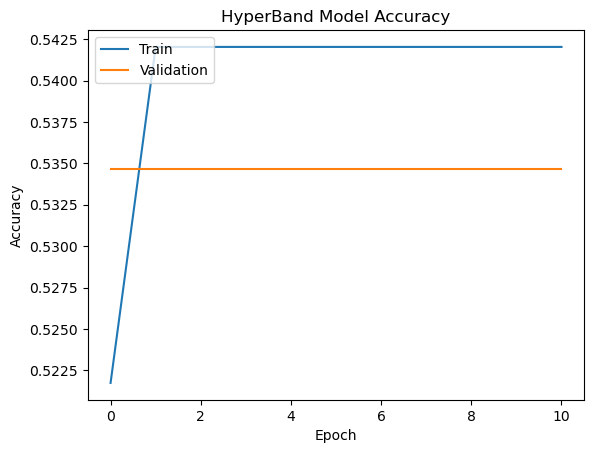

In [132]:
# train the best model using the hyper parameters found by the tuner to 150 epochs
hyper_model = build_model(best_hyper1, input_shape=input_shape)
hyper_history = hyper_model.fit(X1_train_scaled, y1_train, epochs=300, validation_data=(X1_val_scaled, y1_val), callbacks=[early_stopping, performance_threshold])
plt.plot(hyper_history.history['accuracy'])
plt.plot(hyper_history.history['val_accuracy'])
plt.title('HyperBand Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [133]:
# test the new model
model_loss, model_accuracy = hyper_model.evaluate(X1_test_scaled,y1_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

6/6 - 0s - loss: nan - accuracy: 0.4971 - 26ms/epoch - 4ms/step
Loss: nan, Accuracy: 0.4971098303794861


Epoch 1/150
11/11 [==============================] - 1s 42ms/step - loss: nan - accuracy: 0.5072 - val_loss: nan - val_accuracy: 0.5347
Epoch 2/150
11/11 [==============================] - 0s 15ms/step - loss: nan - accuracy: 0.5420 - val_loss: nan - val_accuracy: 0.5347
Epoch 3/150
11/11 [==============================] - 0s 14ms/step - loss: nan - accuracy: 0.5420 - val_loss: nan - val_accuracy: 0.5347
Epoch 4/150
11/11 [==============================] - 0s 14ms/step - loss: nan - accuracy: 0.5420 - val_loss: nan - val_accuracy: 0.5347
Epoch 5/150
11/11 [==============================] - 0s 15ms/step - loss: nan - accuracy: 0.5420 - val_loss: nan - val_accuracy: 0.5347
Epoch 6/150
11/11 [==============================] - 0s 15ms/step - loss: nan - accuracy: 0.5420 - val_loss: nan - val_accuracy: 0.5347
Epoch 7/150
11/11 [==============================] - 0s 15ms/step - loss: nan - accuracy: 0.5420 - val_loss: nan - val_accuracy: 0.5347
Epoch 8/150
11/11 [=============================

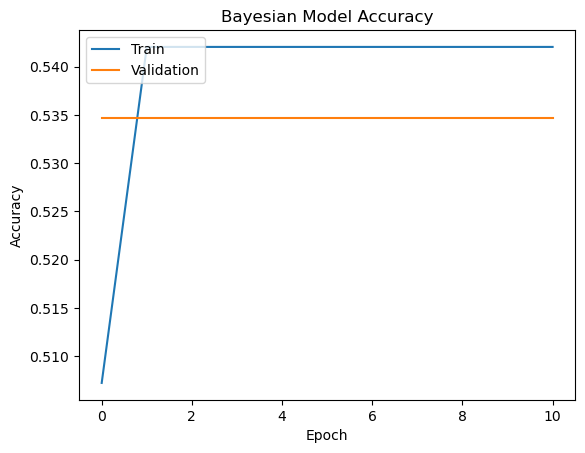

In [134]:
# train the best model using the hyper parameters found by the tuner to 150 epochs
bayesian_model = build_model(best_hyper2, input_shape=input_shape)
bayesian_history = bayesian_model.fit(X1_train_scaled, y1_train, epochs=150, validation_data=(X1_val_scaled, y1_val), callbacks=[early_stopping, performance_threshold])
plt.plot(bayesian_history.history['accuracy'])
plt.plot(bayesian_history.history['val_accuracy'])
plt.title('Bayesian Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [135]:
model_loss, model_accuracy = bayesian_model.evaluate(X1_test_scaled,y1_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

6/6 - 0s - loss: nan - accuracy: 0.4971 - 32ms/epoch - 5ms/step
Loss: nan, Accuracy: 0.4971098303794861


In [136]:
hyperband_top_1 = tuner1.get_best_models(1)[0]
hyperband_top_2 = tuner1.get_best_models(2)[1]
hyperband_top_3 = tuner1.get_best_models(3)[2]
#pretrained_model = load_model("AlphabetSoupCharity.h5")

bayesian_top_1 = tuner2.get_best_models(1)[0]
bayesian_top_2 = tuner2.get_best_models(2)[1]
bayesian_top_3 = tuner2.get_best_models(3)[2]

def ensemble_predictions(models, X):
    # Make predictions
    yhats = [model.predict(X) for model in models]
    yhats = np.array(yhats)
    # Average predictions
    avg_yhat = np.mean(yhats, axis=0)
    # Apply sigmoid
    predictions = np.round(avg_yhat)
    return predictions

models = [hyperband_top_1, hyperband_top_2, hyperband_top_3, bayesian_top_1, bayesian_top_2, bayesian_top_3]
y_pred = ensemble_predictions(models, X1_test_scaled)
ensemble_accuracy = accuracy_score(y1_test, y_pred)
print(f"Ensemble accuracy: {ensemble_accuracy}")

6/6 [==============================] - 0s 14ms/step
Ensemble accuracy: 0.49710982658959535


In [137]:
nn_df = final_df_2.copy()


scaler = MinMaxScaler(feature_range=(0, 1))

# columns to scale
scale_columns = ['my_work_experience', 'my_work_unit', 'my_organization', 'my_supervisor', 'leadership',
                'my_satisfaction', 'employee_experience', 'circumstantial', 'DEIA', 'negativity_index', 'O10', 'O9', 'O8', 'O7', 'O6', 'O5', 'O4', 
                    'O3', 'O2', 'O1', 'W5', 'W4', 'W3', 'W2', 'W1', 'E9', 'E8', 'E7', 
                    'E6', 'E5', 'E4', 'E3', 'E2', 'E1']
# scale the data
nn_df[scale_columns] = scaler.fit_transform(nn_df[scale_columns])

X = nn_df.drop(columns=['O3'], axis=1).values
y = nn_df['O3'].values

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


KeyError: "None of [Index(['my_work_experience', 'my_work_unit', 'my_organization',\n       'my_supervisor', 'leadership', 'my_satisfaction', 'employee_experience',\n       'circumstantial', 'DEIA', 'negativity_index', 'O10', 'O9', 'O8', 'O7',\n       'O6', 'O5', 'O4', 'O3', 'O2', 'O1', 'W5', 'W4', 'W3', 'W2', 'W1', 'E9',\n       'E8', 'E7', 'E6', 'E5', 'E4', 'E3', 'E2', 'E1'],\n      dtype='object')] are in the [columns]"

In [ ]:
# Reshaping data for LSTM input
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Building a Stacked LSTM model
model_stacked = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model_stacked.compile(optimizer='adam', loss='mean_squared_error')

# Fit model
model_stacked.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

In [ ]:
# Make predictions on the test data
y_pred_stacked = model_stacked.predict(X_test)

# Reshape y_pred to ensure it has the same shape as y_test
y_pred_stacked = y_pred_stacked.reshape(y_pred_stacked.shape[0])

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred_stacked)
print(f"Mean Squared Error: {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate R-squared (R2) - Coefficient of Determination
r2 = r2_score(y_test, y_pred_stacked)
print(f"R-squared: {r2}")

In [ ]:
def attention_layer(inputs, time_steps):
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, time_steps))(a)
    a = Dense(time_steps, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

# Input layer
inputs = Input(shape=(1, X_train.shape[2]))

# LSTM layers with attention
lstm_out = LSTM(50, return_sequences=True)(inputs)
attention_mul = attention_layer(lstm_out, 1)
attention_mul = LSTM(50)(attention_mul)

# Final part of the network
output = Dense(1, activation='linear')(attention_mul)

model_attention = Model(inputs=[inputs], outputs=output)

model_attention.compile(optimizer='adam', loss='mean_squared_error')

# Fit model
model_attention.fit([X_train], y_train, epochs=100, batch_size=64, validation_data=([X_test], y_test))

In [ ]:
# Make predictions on the test data
y_pred_attention = model_attention.predict([X_test])

# Reshape y_pred to ensure it has the same shape as y_test
y_pred_attention = y_pred_attention.reshape(y_pred_attention.shape[0])

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred_attention)
print(f"Mean Squared Error: {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error: {rmse}")

# Calculate R-squared (R2) - Coefficient of Determination
r2 = r2_score(y_test, y_pred_attention)
print(f"R-squared: {r2}")
